### Tests on Top1

In [1]:
# standard imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist,pdist,squareform
from scipy.stats import pearsonr
from sklearn import datasets, metrics
from IPython import display
%matplotlib inline

In [2]:
#my code
#import custom functions and classes
import myclusters2
import mymetrics2
import DBCV

In [3]:
%%bash
awk '/hexdump/' mymetrics2.py

#       hexdump -v -e '376/4 "%06f "' -e '"\n"' rmsdm_hex.dat > rmsdm.dat


### Load Data and calculate size independent $\rho$

In [4]:
#data dir
#% cd /scratch/cherry_picking/top1_data
#%cd /home/gmancini/Work/test
%cd /home/gmancini/Work/top1_data/

/home/gmancini/Work/top1_data


In [5]:
RawDist = np.loadtxt("2drms-raw.dat")
RawDist.shape

(3599, 3599)

In [6]:
rgyr_raw = np.loadtxt("rgyr_raw.dat")[:,1]
rho_raw = myclusters2.size_indep_rho(RawDist,rgyr_raw)
rho_raw.shape

(3599, 3599)

### Settings

Settings for percentage of point, noise and metric

In [7]:
spacedef="precomputed"
usenoise="ignore"
percent = np.array((0.5,1.,1.5,2.,2.5,3.))
#percent = np.array((1.,1.5,1.75))
ndata = RawDist.shape[0]

### DP: raw

Using raw RMSD matrix

############################

Determining cutoff using a % of neighbors= 0.5
Cutoff 0.12833


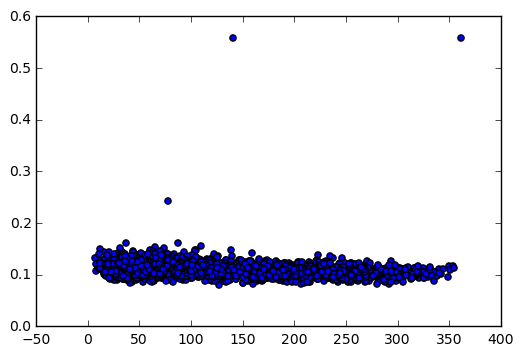


############################

Determining cutoff using a % of neighbors= 1.0
Cutoff 0.13663


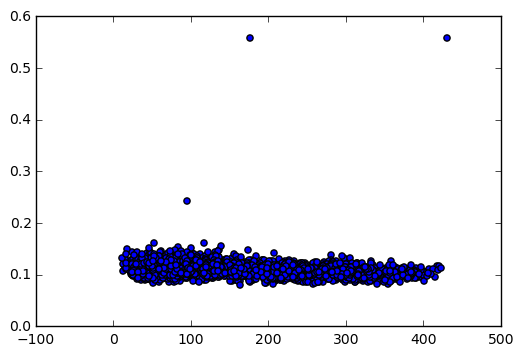


############################

Determining cutoff using a % of neighbors= 1.5
Cutoff 0.142293


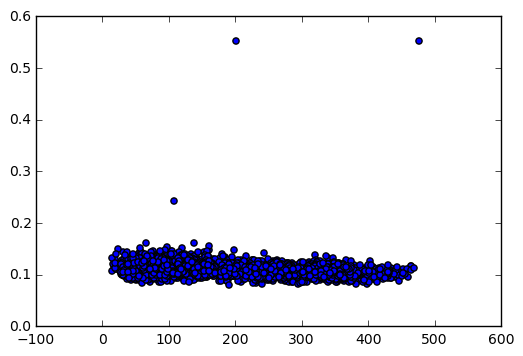


############################

Determining cutoff using a % of neighbors= 2.0
Cutoff 0.146736


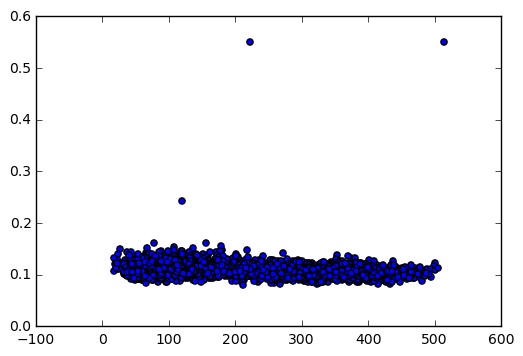


############################

Determining cutoff using a % of neighbors= 2.5
Cutoff 0.150448


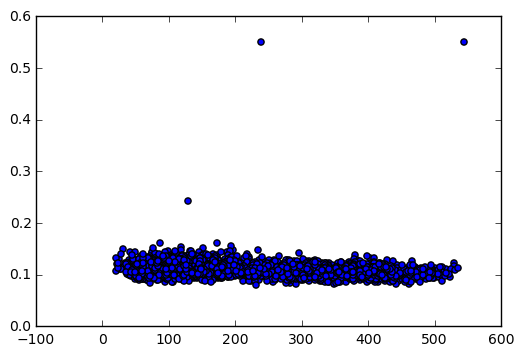


############################

Determining cutoff using a % of neighbors= 3.0
Cutoff 0.153703


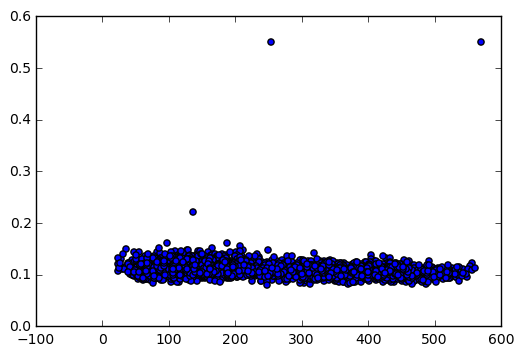

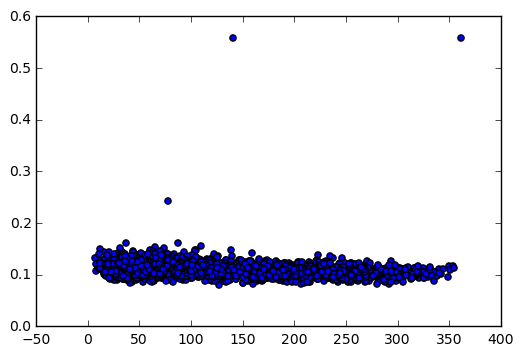

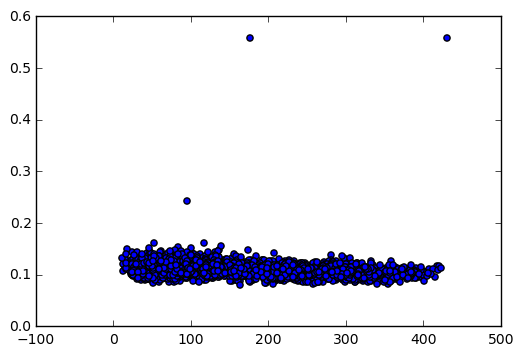

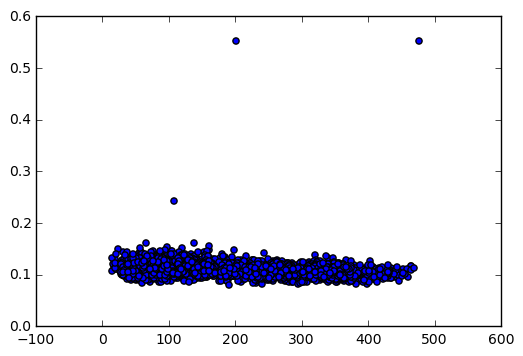

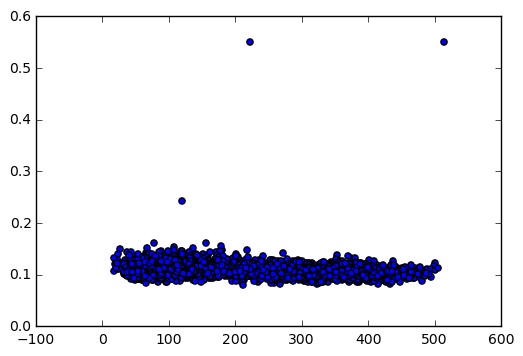

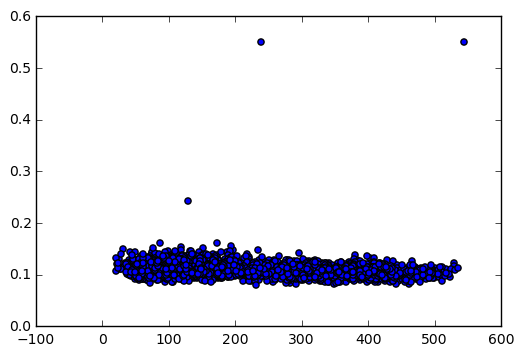

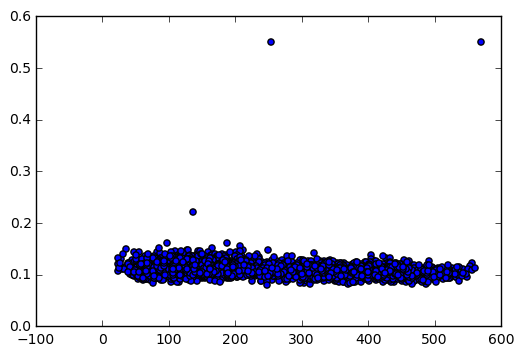

In [8]:
print("Using raw RMSD matrix")
DPrun = list()
for p in percent:
    fig = plt.figure()
    print("\n############################\n")
    ###############
    estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                     kernel="gaussian",D=RawDist)
    print("Cutoff",estimator.cutoff)
    rho,delta = estimator.decision_graph()
    plt.scatter(rho,delta)
    DPrun.append(estimator)
    display.display(fig)

In [9]:
RMIN = 90
DELTA = 0.2

In [10]:
for rr,run in enumerate(DPrun):
    VI = np.zeros((4,2))
    print("\n############################\n")
    myrun = DPrun[rr]
    centroids,points = myrun.get_centroids(rmin=RMIN,dmin=DELTA)
    clusters = myrun.assign_points()

    robust_clusters = myrun.create_halo()
    halo = 0
    for c in centroids:
        N = len(robust_clusters[robust_clusters==c])
        H = len(clusters[clusters==c]) - N
        halo = halo + H
        print("%d elements and %d HALO points found in cluster %d" % (N,H,c))        

    dens_score = DBCV.DBCV(clusters=robust_clusters,metric=spacedef,NF=1130,D=RawDist)
    dbcv = dens_score.calc_score(meas='kernel')
    
    sil = metrics.silhouette_score(RawDist,robust_clusters,metric=spacedef)
    myeval = mymetrics2.cluster_eval(metric=spacedef,clusters=robust_clusters,D=RawDist)
    DBI = myeval(noise=usenoise,method="DBI")
    Dunn = myeval(noise=usenoise,method="Dunn",inter="allav",intra="allav")
    psf,wss = myeval(noise=usenoise,method="psF",centroid=True)
    norm = (ndata-halo)/ndata
    print("Penalty: ",norm)
    print("%8s %8s %8s %8s %8s" % ("Sil","DBI","Dunn","psF","DBCV"))
    print("%9.5f %9.5f %9.5f %9.5f %9.5f"%(sil,DBI,Dunn,psf,dbcv))
    print("%9.5f %9.5f %9.5f %9.5f"%(sil*norm,DBI/norm,Dunn*norm,psf*norm))
    VI[0,0] = sil
    VI[0,1] = sil*norm
    VI[1,0] = DBI
    VI[1,1] = DBI/norm
    VI[2,0] = Dunn
    VI[2,1] = Dunn*norm
    VI[3,0] = psf
    VI[3,1] = psf*norm
    correl = pearsonr(VI[:,0],VI[:,1])
    print("Correl: ",correl)


############################

1800 elements and 0 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty:  1.0
     Sil      DBI     Dunn      psF     DBCV
  0.57574   0.64907   1.99162 14632.70705   0.32890
  0.57574   0.64907   1.99162 14632.70705
Correl:  (1.0, 0.0)

############################

47 elements and 285 HALO points found in cluster 1326
806 elements and 662 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty:  0.7368713531536538
     Sil      DBI     Dunn      psF     DBCV
  0.30257   0.73697   1.92746 8169.74136   0.05311
  0.22296   1.00014   1.42029 6020.04837
Correl:  (0.9999999974371423, 2.5628577038361312e-09)

############################

12 elements and 305 HALO points found in cluster 1326
735 elements and 748 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty:  0.7074187274242846
     Sil      DBI     Dunn      psF     DBCV
  0.28

In [11]:
print("---------  CENTROIDS");print(centroids)
print("---------  CLUSTERS");print(clusters)
print("---------  ROBUST CLUSTERS");print(robust_clusters)

---------  CENTROIDS
[1326 1787 2967]
---------  CLUSTERS
[1787 1787 1787 ..., 2967 2967 2967]
---------  ROBUST CLUSTERS
[  -1   -1   -1 ..., 2967 2967 2967]


### DP: $\rho_{raw}$

Using rho

############################

Determining cutoff using a % of neighbors= 0.5
Cutoff 0.0682303372243


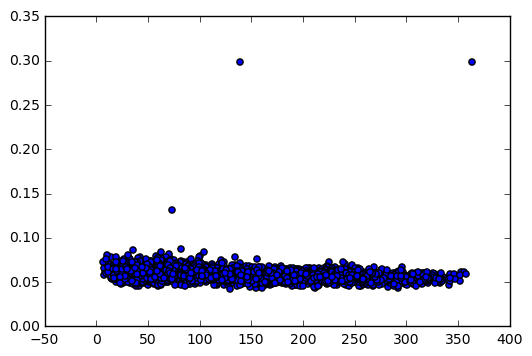


############################

Determining cutoff using a % of neighbors= 1.0
Cutoff 0.0726405358707


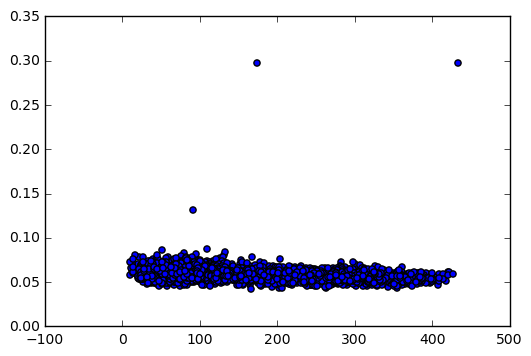


############################

Determining cutoff using a % of neighbors= 1.5
Cutoff 0.0756566340124


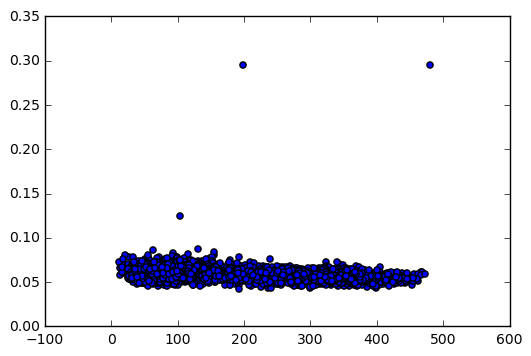


############################

Determining cutoff using a % of neighbors= 2.0
Cutoff 0.0780185034005


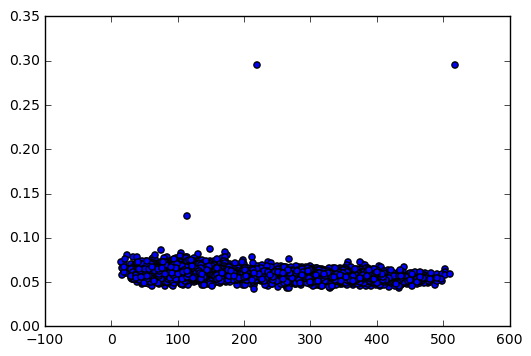


############################

Determining cutoff using a % of neighbors= 2.5
Cutoff 0.0799991238747


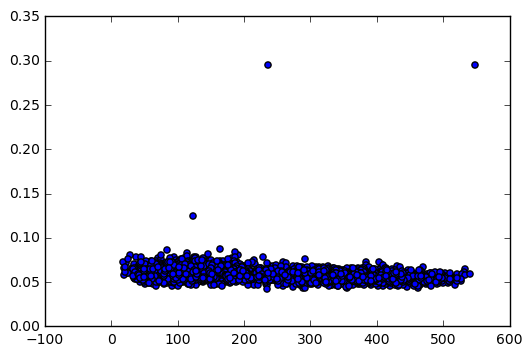


############################

Determining cutoff using a % of neighbors= 3.0
Cutoff 0.0817271341806


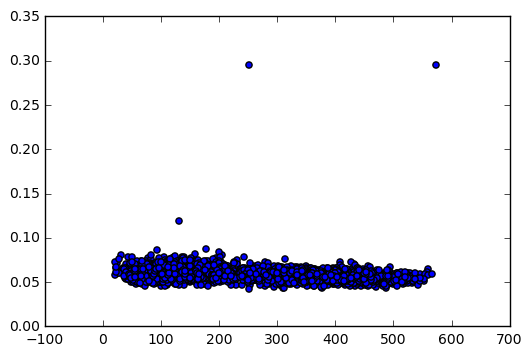

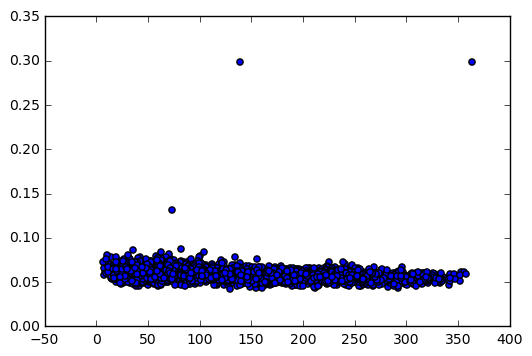

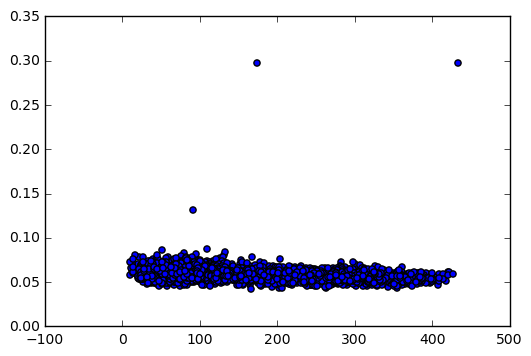

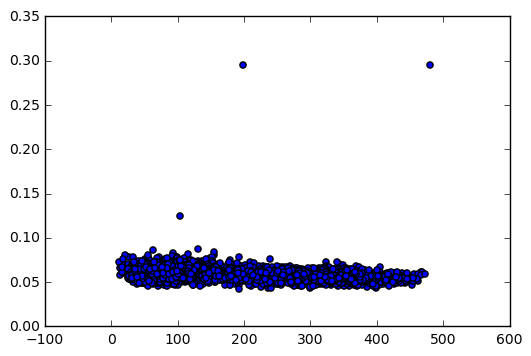

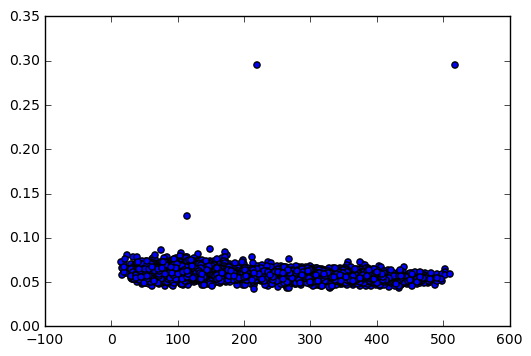

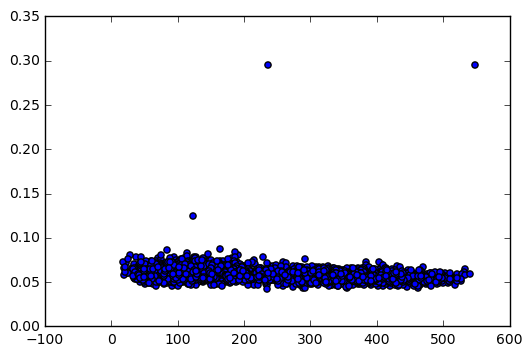

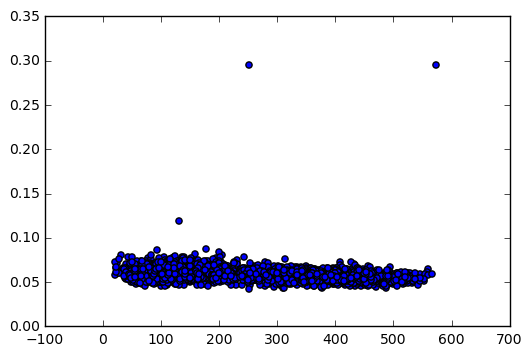

In [12]:
print("Using rho")
DPrun = list()
for p in percent:
    print("\n############################\n")
    ###############
    fig = plt.figure()
    estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                     kernel="gaussian",D=rho_raw)
    print("Cutoff",estimator.cutoff)
    rho,delta = estimator.decision_graph()
    plt.scatter(rho,delta)
    display.display(fig)
    DPrun.append(estimator)

In [13]:
RMIN = 90
DELTA = 0.1

In [14]:
for rr,run in enumerate(DPrun):
    print("\n############################\n")
    VI = np.zeros((4,2))
    myrun = DPrun[rr]
    centroids,points = myrun.get_centroids(rmin=RMIN,dmin=DELTA)
    clusters = myrun.assign_points()

    robust_clusters = myrun.create_halo()
    halo = 0
    for c in centroids:
        N = len(robust_clusters[robust_clusters==c])
        H = len(clusters[clusters==c]) - N
        halo = halo + H
        print("%d elements and %d HALO points found in cluster %d" % (N,H,c))        

    dens_score = DBCV.DBCV(clusters=robust_clusters,metric=spacedef,NF=1130,D=rho_raw)
    dbcv = dens_score.calc_score(meas='kernel')
    
    dens_score = DBCV.DBCV(clusters=robust_clusters,metric=spacedef,NF=1130,D=RawDist)
    dbcv = dens_score.calc_score(meas='kernel')
    
    sil = metrics.silhouette_score(RawDist,robust_clusters,metric=spacedef)
    myeval = mymetrics2.cluster_eval(metric=spacedef,clusters=robust_clusters,D=RawDist)
    DBI = myeval(noise=usenoise,method="DBI")
    Dunn = myeval(noise=usenoise,method="Dunn",inter="allav",intra="allav")
    psf,wss = myeval(noise=usenoise,method="psF",centroid=True)
    norm = (ndata-halo)/ndata
    print("Penalty ",norm)
    print("%8s %8s %8s %8s %8s" % ("Sil","DBI","Dunn","psF","DBCV"))
    print("%9.5f %9.5f %9.5f %9.5f %9.5f"%(sil,DBI,Dunn,psf,dbcv))
    print("%9.5f %9.5f %9.5f %9.5f"%(sil*norm,DBI/norm,Dunn*norm,psf*norm))
    VI[0,0] = sil
    VI[0,1] = sil*norm
    VI[1,0] = DBI
    VI[1,1] = DBI/norm
    VI[2,0] = Dunn
    VI[2,1] = Dunn*norm
    VI[3,0] = psf
    VI[3,1] = psf*norm
    correl = pearsonr(VI[:,0],VI[:,1])
    print("Correl: ",correl)       


############################

1800 elements and 0 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty  1.0
     Sil      DBI     Dunn      psF     DBCV
  0.57574   0.64907   1.99162 14632.70705   0.32890
  0.57574   0.64907   1.99162 14632.70705
Correl:  (1.0, 0.0)

############################

48 elements and 289 HALO points found in cluster 1326
807 elements and 656 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty  0.7374270630730758
     Sil      DBI     Dunn      psF     DBCV
  0.30143   0.73707   1.91307 8172.97429   0.04804
  0.22228   0.99951   1.41075 6026.97243
Correl:  (0.99999999745539725, 2.5446027507314288e-09)

############################

21 elements and 297 HALO points found in cluster 1325
776 elements and 706 HALO points found in cluster 1787
1799 elements and 0 HALO points found in cluster 2967
Penalty  0.7213114754098361
     Sil      DBI     Dunn      psF     DBCV
  0.2892